# Calculating size classes from PACE L3 chlorophyll-a data

**Author:** Yanna Fidai

<div class="alert alert-success" role="alert">


<div



In [1]:
## import everthing needed and authorise earth access

In [2]:
import earthaccess
import xarray as xr
import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt


auth = earthaccess.login(persist=True)



In [3]:
## search for the data in the relevant time period and product

In [4]:
# Define the time span
tspan = ("2024-07-07", "2024-08-05")

# Search for the data
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL_NRT",
    granule_name="*.DAY.*.4km.*",
    temporal=tspan,
)

# Print the number of results found
print(len(results))

30


In [5]:
## open the products, loop through and extract the date, calculate the mean chl, and save as csv

In [6]:
# Print the structure of one of the results to identify the correct attribute 
## - this is not esential and was just helpful for me to pull out attributes in the next cell.
print(results[0])

Collection: {'Version': '2.0', 'ShortName': 'PACE_OCI_L3M_CHL_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'SouthBoundingCoordinate': -90, 'WestBoundingCoordinate': -180, 'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 90}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-07-07T23:59:59Z', 'BeginningDateTime': '2024-07-07T00:00:00Z'}}
Size(MB): 12.020511627197266
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240707.L3m.DAY.CHL.V2_0.chlor_a.4km.NRT.nc']


In [7]:

# Open the paths for the results
paths = earthaccess.open(results)

# Initialize a list to store the data
data = []

# Loop through each file, open it, compute the mean, and store the results
for path in paths:
    # Open the dataset
    dataset = xr.open_dataset(path)
    dataset = dataset.drop_vars("palette")
    datetime = np.datetime64(dataset.attrs["time_coverage_start"][:-1], "ns")
    
    # Subset the data to the specified region
    region = dataset.sel(lon=slice(-159, -157.5), lat=slice(28, 26))
    
    # Calculate the mean chlorophyll value for the region
    region_mean = region.mean(dim=("lon", "lat"))
    
    # Append the date and mean value to the data list
    data.append([datetime, region_mean["chlor_a"].values])

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=["Date", "Chl_Mean"])

# Save the DataFrame to a CSV file
df.to_csv("chl_means.csv", index=False)

print("CSV file saved as 'chl_means.csv'")

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

CSV file saved as 'chl_means.csv'


In [8]:
## Use Brewin's formulas to calculate the percentage of each size class in the chl-a profile, save as csv

In [9]:
# Define the formulas using functions, where B is chl-a (linear)
def calculate_picophytoplankton(B):
    """
    Calculate picophytoplankton (Bp) concentration.
    B: chlorophyll-a value (Chl_Mean)
    Return: Bp value
    """
    return 0.13 * (1 - np.exp(-6.15 * B))

def calculate_nanophytoplankton(B):
    """
    Calculate nanophytoplankton (Bm) concentration.
    B: chlorophyll-a value (Chl_Mean)
    Return: Bm value
    """
    Bpn = 0.77 * (1 - np.exp(-1.26 * B))
    return B - Bpn

def calculate_microphytoplankton(B):
    """
    Calculate microphytoplankton (Bn) concentration.
    B: chlorophyll-a value (Chl_Mean)
    Return: Bn value
    """
    Bp = calculate_picophytoplankton(B)
    Bpn = 0.77 * (1 - np.exp(-1.26 * B))
    return Bpn - Bp


data = pd.read_csv('chl_means.csv')

# Apply the formulas to the 'chl-v6.0' column
data['pico'] = data['Chl_Mean'].apply(calculate_picophytoplankton)
data['nano'] = data['Chl_Mean'].apply(calculate_nanophytoplankton)
data['micro'] = data['Chl_Mean'].apply(calculate_microphytoplankton)

# Calculate percentages
data['pico_percent'] = (data['pico'] / data['Chl_Mean']) * 100
data['nano_percent'] = (data['nano'] / data['Chl_Mean']) * 100
data['micro_percent'] = (data['micro'] / data['Chl_Mean']) * 100

# Save the DataFrame to a CSV file
data.to_csv("size_classes.csv", index=False)

print('csv saved')


csv saved


In [10]:
## plot the percentages

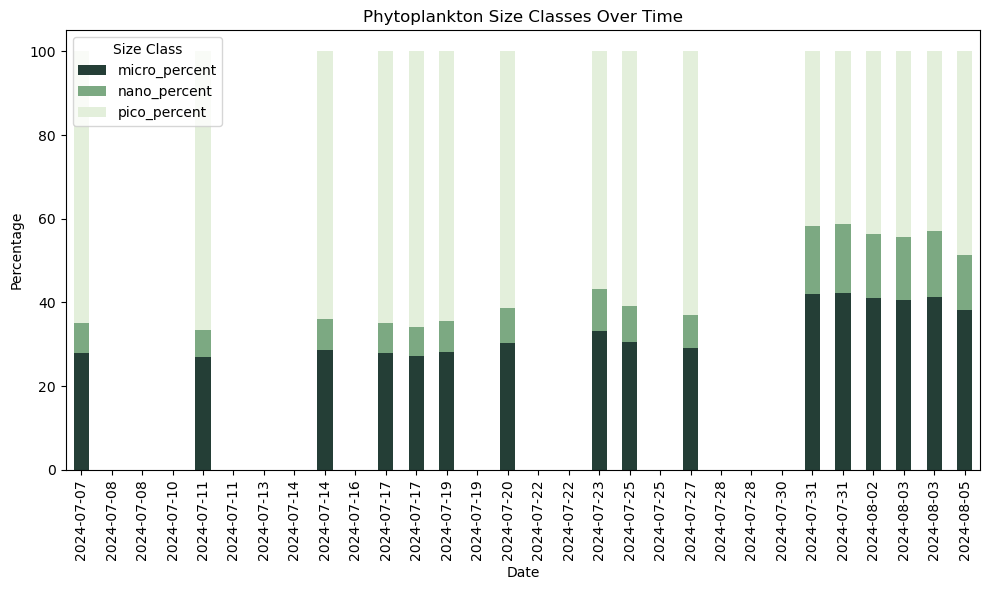

In [11]:
# Load the data
df = pd.read_csv("size_classes.csv")

# Ensure the date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Remove the time from the date
df['Date'] = df['Date'].dt.date

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Set the date column as the index
df.set_index('Date', inplace=True)

# Select the specific columns for plotting
columns_to_plot = ['micro_percent', 'nano_percent', 'pico_percent']

# Define custom colors
custom_colors = ['#243e36', '#7ca982', '#e3efdb'] 

# Plot the data
ax = df[columns_to_plot].plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_colors)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Percentage")
ax.set_title("Phytoplankton Size Classes Over Time")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Add legend
plt.legend(title="Size Class")

# Show the plot
plt.tight_layout()
plt.show()


In [12]:
## explore trends in the data

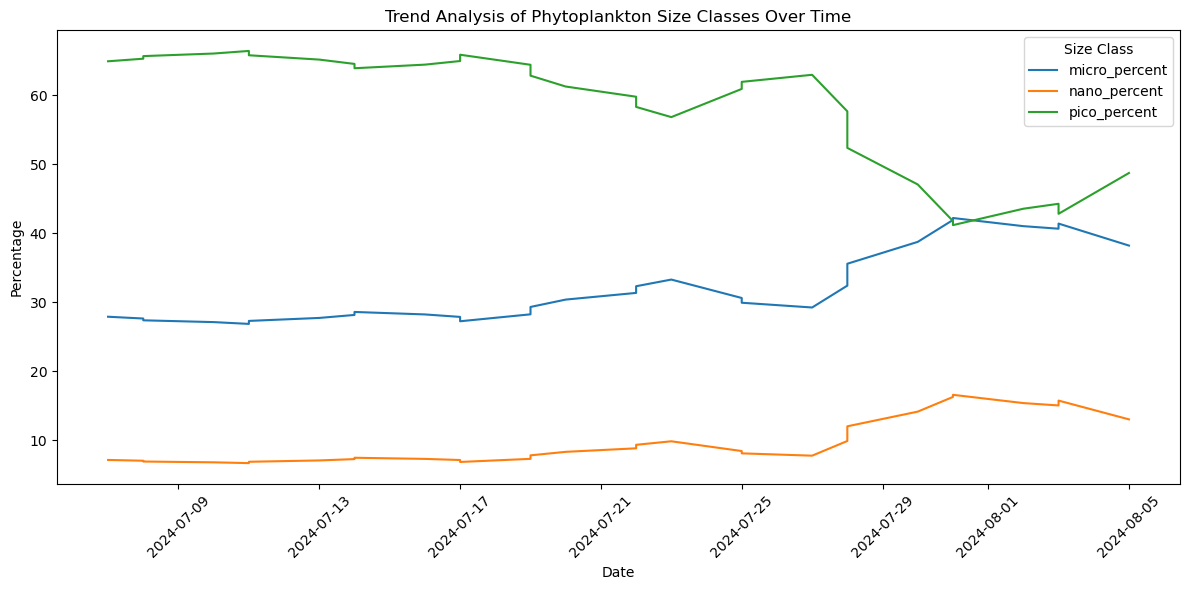

In [13]:
# Load the data
df = pd.read_csv("size_classes.csv")

# Ensure the date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Remove the time from the date
df['Date'] = df['Date'].dt.date

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Set the date column as the index
df.set_index('Date', inplace=True)

# Interpolate missing values
df_interpolated = df.interpolate(method='linear')

# Plot the interpolated data
plt.figure(figsize=(12, 6))

# Plot each size class
for column in ['micro_percent', 'nano_percent', 'pico_percent']:
    plt.plot(df_interpolated.index, df_interpolated[column], label=column)

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Percentage")
plt.title("Trend Analysis of Phytoplankton Size Classes Over Time")

# Add legend
plt.legend(title="Size Class")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()